In [1]:
from pandas import read_csv
from datetime import datetime
import matplotlib as mpl
from matplotlib import pylab as plt
import matplotlib.dates as mdates
import pandas as pd
import collections
import seaborn as sns
import numpy as np
import tensorflow as tf

from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM
import pickle
from keras import backend as K


Using TensorFlow backend.


In [2]:
# load data
currencies = ['EXR.D.AUD.EUR.SP00.A', 'EXR.D.BRL.EUR.SP00.A', 'EXR.D.CAD.EUR.SP00.A', 'EXR.D.CNY.EUR.SP00.A', 'EXR.D.GBP.EUR.SP00.A',
              'EXR.D.HKD.EUR.SP00.A', 'EXR.D.IDR.EUR.SP00.A', 'EXR.D.INR.EUR.SP00.A', 'EXR.D.JPY.EUR.SP00.A', 'EXR.D.MYR.EUR.SP00.A']
currencies = ['EXR.D.AUD.EUR.SP00.A', 'EXR.D.BRL.EUR.SP00.A', 'EXR.D.CNY.EUR.SP00.A', 'EXR.D.GBP.EUR.SP00.A',
              'EXR.D.HKD.EUR.SP00.A', 'EXR.D.IDR.EUR.SP00.A', 'EXR.D.INR.EUR.SP00.A', 'EXR.D.JPY.EUR.SP00.A']


currencies = ['EXR.D.INR.EUR.SP00.A']

def builData():
    
    print('Loading data and parsing date')
    
    def parse(x):
        return datetime.strptime(x, '%Y-%m-%d')

    df = read_csv('EURUSD_H1.csv', delimiter=',')
    print('Data loaded succesfully ')
    print(df.head(5))

    # dataset.index.name = 'date'

    # dataset.drop('Unnamed: 0', axis=1, inplace=True)

    # mark all NA values with 0
    keep_cur = ['<CLOSE>']
    
    for curr in df.columns:
        if curr in keep_cur:
            print('Reading currency: ', curr)
        else:
            df.drop(curr, axis=1, inplace=True)  
            print('Deleted currency: ', curr)


    df.info()
    print(df.head(5))
    curr_key = df.columns
    return df

In [3]:
curr_key = ['EURUSD_H1']
#df = builData()
#df.to_pickle('EURUSD_H1')

In [99]:
def prepareData(df):
    #creating train and test sets

    start = 24 * 30 * 3
    # df.columns.drop(['Unnamed: 0', 'date'])

    dataset = df.values

    dataset = np.array(dataset)
    dataset = dataset[-start:, :].astype(np.float64)
    print(dataset.shape)
    n_curr = len(df.columns)

    train_size = int(dataset.shape[0]*0.8)

    train = dataset[:train_size, :]
    valid = dataset[train_size:, :]
    #converting dataset into x_train and y_train
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_data = scaler.fit_transform(train)
    scaled_data_test = scaler.fit_transform(valid)

    x_train, y_train = [], []
    x_test, y_test = [], []

    lookback = 24*3
    for i in range(lookback,len(train)):
        x_train.append(scaled_data[i-lookback:i,:])
        y_train.append(scaled_data[i,:])
        
    for i in range(lookback,len(valid)):
        x_test.append(scaled_data_test[i-lookback:i,:])
        y_test.append(scaled_data_test[i,:])

    x_train, y_train = np.array(x_train), np.array(y_train)
    x_test, y_test = np.array(x_test), np.array(y_test)

    x_train = np.reshape(x_train, (x_train.shape[0],x_train.shape[1], n_curr))
    x_test = np.reshape(x_test, (x_test.shape[0],x_test.shape[1], n_curr))
    
    #indices = np.arange(x_train.shape[0])
    #np.random.shuffle(indices)

    #x_train = x_train[indices, :, :]
    #y_train = y_train[indices, :]
    

    print(x_train.shape)
    
    print(y_train.shape)
    return x_train, y_train, x_test, y_test, scaler

In [100]:
def root_mean_squared_error(y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true)))

def buildModel(x_train, y_train, curr_key):
    i = 0
    units = 50
    for curr in curr_key:
        # create and fit the LSTM network
        model = Sequential()
        #model.add(LSTM(units=units, return_sequences=True, input_shape=(x_train.shape[1], 1)))
        model.add(LSTM(units=units))
        #model.add(Dropout(0.2))
        model.add(Dense(1))
        X = x_train[:, :, i].reshape(x_train.shape[0], x_train.shape[1], 1)
        y = y_train[:, i]
        
        

        model.compile(loss='mean_squared_error', optimizer='Adamax')
        history = model.fit(X, y, epochs=1, batch_size=1, verbose=1)
        filename = curr + '_model.sav'
        pickle.dump(model, open(filename, 'wb'))
        print('Model created :', curr)
        

        i += 1
        
        
    print('Total created models: ', i)
    return [model]
    

In [101]:
def loadModel(curr_key):
    i = 0
    models = []
    for curr in curr_key:
        # load the model from disk
        filename = curr + '_model.sav'
        loaded_model = pickle.load(open(filename, 'rb'))
        models.append(loaded_model)
        print('Loaded model: ', filename)
    return models

In [102]:
def predict(x_test, models):
    predict_arr = np.zeros((x_test.shape[0], len(models)))

    i = 0
    for model in models:
        X = x_test[:, :, i].reshape(x_test.shape[0], x_test.shape[1], 1)
        
        prediction = model.predict(X)
        predict_arr[:, i] = prediction.reshape(prediction.shape[0],)
        i += 1
    return predict_arr

In [103]:
def getMSE(x_train, y_train, models, scaler):
    i = 0
    mse_arr = []
    ps = 0*y_train
    for model in models:
        X = x_train[:, :, i].reshape(x_train.shape[0], x_train.shape[1], 1)
        p = model.predict(X)
        ps[:, i] = p.reshape(p.shape[0],)
        i += 1

    y_train_inv = scaler.inverse_transform(y_train)
    predict = scaler.inverse_transform(ps)
        
    for j in range(len(models)):
        mse = mean_squared_error(y_train_inv[:, j], predict[:, j])
        mse_arr.append(mse)
    return mse_arr

In [104]:
df = pd.read_pickle('EURUSD_H1')
df.head(5)

,<CLOSE>
0,1.19219
1,1.19220
2,1.19331
3,1.19359
4,1.19199


In [105]:
x_train, y_train, x_test, y_test, scaler = prepareData(df)

(2160, 1)
(1656, 72, 1)
(1656, 1)


In [106]:
print(curr_key)
models = buildModel(x_train, y_train, curr_key)

['EURUSD_H1']
Epoch 1/1
1656/1656 [==============================] - 43s 26ms/step - loss: 0.0034
Model created : EURUSD_H1
Total created models:  1


In [107]:
#models = loadModel(curr_key)

In [108]:
predict_arr = predict(x_test, models)

In [109]:
y_test_inv = scaler.inverse_transform(y_test)
predict = scaler.inverse_transform(predict_arr)

horizon = 24*10

In [110]:
def getActions(y, V, Cash, T):
    n = V.shape[1]
    t_cur = T
    t_prev = t_cur - 1
    t_prev2 = t_prev - 1
    t_next = t_cur + 1
    
    X_eur = Cash[t_cur, -1]
    X_new = X_eur
    A = []
    
    for c in range(n):
        action = ''
        X = 0

        d_cur = y[t_prev, c] - y[t_prev2, c]
        d_next = V[t_cur, c] - y[t_prev, c]

        if d_cur > 0 and d_next < 0:
            action = 'BUY'

        elif d_cur < 0 and d_next > 0:
            action = 'SELL'
        A.append([action, X])
    
    return A

In [111]:
for j in range(len(curr_key)):
    mse = mean_squared_error(y_test[:, j], predict_arr[:, j])
    print(mse)

0.004423014945799359


In [112]:
V = predict[-horizon:, :]
y = y_test_inv[-horizon:, :]

n = V.shape[1]
initial_cash = 1000
X_buy = 0*V
X_sell = 0*V

Cash = np.zeros((horizon+1, n + 1))
Cash[0, -1] = initial_cash
Cash[1, -1] = initial_cash
print('n ', n)

for t in range(2, horizon):
    A = getActions(y, V, Cash, t)
    Cash[t, :] = Cash[t-1, :]
    b = 0
    c = 0
    
    print('Heur ', t)
    for a in A:        
        if a[0] == 'SELL' and Cash[t, c] > 0:
            print(str(a[0]) + ' ' + str(Cash[t, c]) + ' ' + str(curr_key[c]) + ' rate :' + str(y[t, c]))
            
            Cash[t, -1] = Cash[t, -1] + Cash[t, c]/y[t, c]
            Cash[t, c] = Cash[t, c] -  Cash[t, c]
            X_sell[t, c] = 1
            
            
            print('Euro after sell ', Cash[t, -1])
        if a[0] == 'BUY':
            b += 1
        c += 1
          
    c = 0    
    for a in A:
            
        if a[0] == 'BUY' and Cash[t, -1] > 0:
            
            print(str(a[0]) + ' ' + str(Cash[t, -1]*y[t, c]/b) + ' ' + str(curr_key[c]) + ' rate: ' + str(y[t, c]/b))
            
            Cash[t, c] = Cash[t, c] + Cash[t, -1]*y[t, c]/b
            Cash[t, -1] = Cash[t, -1] - Cash[t, -1]/b
            
            print('Euro after buy ', Cash[t, -1])
            X_buy[t, c] = 1
        
        c += 1
    
    print('Actions end of hour: ', A)
    print('Accounts status: ', Cash[t, :])
    last_day = t

final_cash = Cash[last_day, -1]
print(final_cash)
for i in range(n):
    if y[last_day, i] != 0:
        final_cash += Cash[last_day, i]/y[last_day, i]
        initial_cash += Cash[0, i]/y[0, i]

d_growth = (final_cash/initial_cash)**(1/(horizon/24)) - 1
                 
print('Initial cash value (eur): ', initial_cash)
print('Final cash value (eur): ', final_cash)
print('Daily growth: ', d_growth, '%')
print('Win: ', final_cash - initial_cash)

n  1
Heur  2
Actions end of hour:  [['', 0]]
Accounts status:  [   0. 1000.]
Heur  3
Actions end of hour:  [['', 0]]
Accounts status:  [   0. 1000.]
Heur  4
Actions end of hour:  [['SELL', 0]]
Accounts status:  [   0. 1000.]
Heur  5
Actions end of hour:  [['', 0]]
Accounts status:  [   0. 1000.]
Heur  6
Actions end of hour:  [['SELL', 0]]
Accounts status:  [   0. 1000.]
Heur  7
Actions end of hour:  [['SELL', 0]]
Accounts status:  [   0. 1000.]
Heur  8
Actions end of hour:  [['SELL', 0]]
Accounts status:  [   0. 1000.]
Heur  9
Actions end of hour:  [['', 0]]
Accounts status:  [   0. 1000.]
Heur  10
BUY 1112.27 EURUSD_H1 rate: 1.11227
Euro after buy  0.0
Actions end of hour:  [['BUY', 0]]
Accounts status:  [1112.27    0.  ]
Heur  11
Actions end of hour:  [['BUY', 0]]
Accounts status:  [1112.27    0.  ]
Heur  12
SELL 1112.27 EURUSD_H1 rate :1.11172
Euro after sell  1000.494728888569
Actions end of hour:  [['SELL', 0]]
Accounts status:  [   0.         1000.49472889]
Heur  13
Actions end o

Accounts status:  [  0.         997.22274172]
Heur  155
Actions end of hour:  [['SELL', 0]]
Accounts status:  [  0.         997.22274172]
Heur  156
Actions end of hour:  [['', 0]]
Accounts status:  [  0.         997.22274172]
Heur  157
Actions end of hour:  [['SELL', 0]]
Accounts status:  [  0.         997.22274172]
Heur  158
Actions end of hour:  [['SELL', 0]]
Accounts status:  [  0.         997.22274172]
Heur  159
Actions end of hour:  [['SELL', 0]]
Accounts status:  [  0.         997.22274172]
Heur  160
BUY 1112.0329959767696 EURUSD_H1 rate: 1.11513
Euro after buy  0.0
Actions end of hour:  [['BUY', 0]]
Accounts status:  [1112.03299598    0.        ]
Heur  161
SELL 1112.0329959767696 EURUSD_H1 rate :1.11514
Euro after sell  997.2137991433987
Actions end of hour:  [['SELL', 0]]
Accounts status:  [  0.         997.21379914]
Heur  162
Actions end of hour:  [['', 0]]
Accounts status:  [  0.         997.21379914]
Heur  163
Actions end of hour:  [['', 0]]
Accounts status:  [  0.         9

rmse:  4.3610515674339154e-07


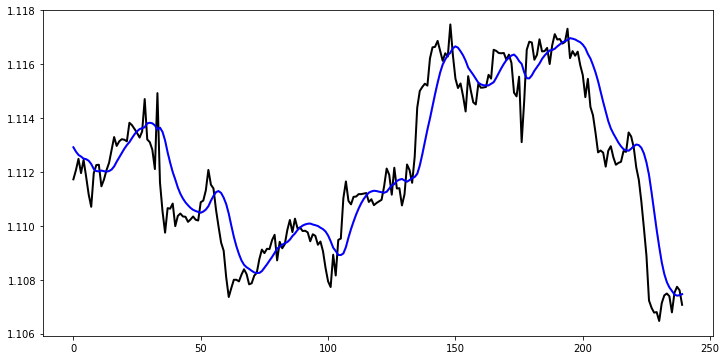

In [113]:
mse_arr = getMSE(x_train, y_train, models, scaler)
for i in range(len(curr_key)):
    xs = np.arange(int(horizon))
    fig = plt.figure(figsize=(12, 6))
    ax = fig.add_subplot(1, 1, 1)

    ax.plot(xs, y_test_inv[-horizon:, i], label='Real ' + curr_key[i], lw=2, color='black')
    ax.plot(xs, predict[-horizon:, i], label='Forecast ' + curr_key[i], lw=2, color='blue')
    

    rmse = mse_arr[i]
    print('rmse: ', rmse)

    rmse_max = [float(p) + float(rmse)/2 for p in predict[:, i]]
    rmse_min = [float(p) - float(rmse)/2 for p in predict[:, i]]

    ax.fill_between(xs, rmse_max[-horizon:], rmse_min[-horizon:], color='red', alpha=0.2)
    plt.show()

In [ ]:
-